[tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

# Setup

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import `matplotlib` and create a helper function to plot graphs

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('Text: ', example.numpy())
  print('Label: ', label.numpy())

Text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label:  0


Next shuffle the data for training and create batches of these (text, label) pairs:

In [ ]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print("Texts: ", example.numpy()[:3])
  print("Labels: ", label.numpy()[:3])

Texts:  [b"I'm sure that most people already know the story-the miserly Ebenezer Scrooge gets a visit from three spirits (the Ghosts of Christmas Past, Present and Yet to Come) who highlight parts of his life in the hopes of saving his soul and changing his ways. Dickens' classic story in one form or another has stood the test of time to become a beloved holiday favorite.<br /><br />While I grew up watching the 1951 version starring Alastair Sims, and I believe that he is the definitive Scrooge, I have been impressed with this version, which was released when I was in high school. George C. Scott plays a convincing and mean Ebenezer Scrooge, and the actors playing the ghosts are rather frightening and menacing. David Warner is a good Bob Cratchit as well.<br /><br />This version is beautifully filmed, and uses more modern filming styles (for the 1980's) which make it more palatable for my children than the 1951 black and white version.<br /><br />This is a worthy adaptation of the stor

# Create the text encoder

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[142, 243,  12, ...,   0,   0,   0],
       [414,   1,  59, ...,   0,   0,   0],
       [ 15,  48,  14, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I'm sure that most people already know the story-the miserly Ebenezer Scrooge gets a visit from three spirits (the Ghosts of Christmas Past, Present and Yet to Come) who highlight parts of his life in the hopes of saving his soul and changing his ways. Dickens' classic story in one form or another has stood the test of time to become a beloved holiday favorite.<br /><br />While I grew up watching the 1951 version starring Alastair Sims, and I believe that he is the definitive Scrooge, I have been impressed with this version, which was released when I was in high school. George C. Scott plays a convincing and mean Ebenezer Scrooge, and the actors playing the ghosts are rather frightening and menacing. David Warner is a good Bob Cratchit as well.<br /><br />This version is beautifully filmed, and uses more modern filming styles (for the 1980's) which make it more palatable for my children than the 1951 black and white version.<br /><br />This is a worthy adaptation of the st

# Create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00146817]


In [ ]:
# predict on a sample text with padding
padding = "the " * 200
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 87ms/step
[-0.00146817]


In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

# Train the model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 53s 110ms/step - loss: 0.6729 - accuracy: 0.5324 - val_loss: 0.6226 - val_accuracy: 0.6042
Epoch 2/10
391/391 [==============================] - 36s 93ms/step - loss: 0.5390 - accuracy: 0.7264 - val_loss: 0.4650 - val_accuracy: 0.7604
Epoch 3/10
391/391 [==============================] - 38s 96ms/step - loss: 0.4981 - accuracy: 0.7828 - val_loss: 0.4098 - val_accuracy: 0.8141
Epoch 4/10
391/391 [==============================] - 29s 73ms/step - loss: 0.3751 - accuracy: 0.8355 - val_loss: 0.3622 - val_accuracy: 0.8318
Epoch 5/10
391/391 [==============================] - 37s 95ms/step - loss: 0.3446 - accuracy: 0.8510 - val_loss: 0.3174 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 27s 67ms/step - loss: 0.3308 - accuracy: 0.8564 - val_loss: 0.3166 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 30s 75ms/step - loss: 0.3190 - accuracy: 0.8632 - val_loss: 0.3374 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test loss: ', test_loss)
print('Test acc: ', test_acc)

391/391 [==============================] - 13s 31ms/step - loss: 0.3269 - accuracy: 0.8489
Test loss:  0.32692912220954895
Test acc:  0.8488799929618835


(0.0, 0.6915187999606133)

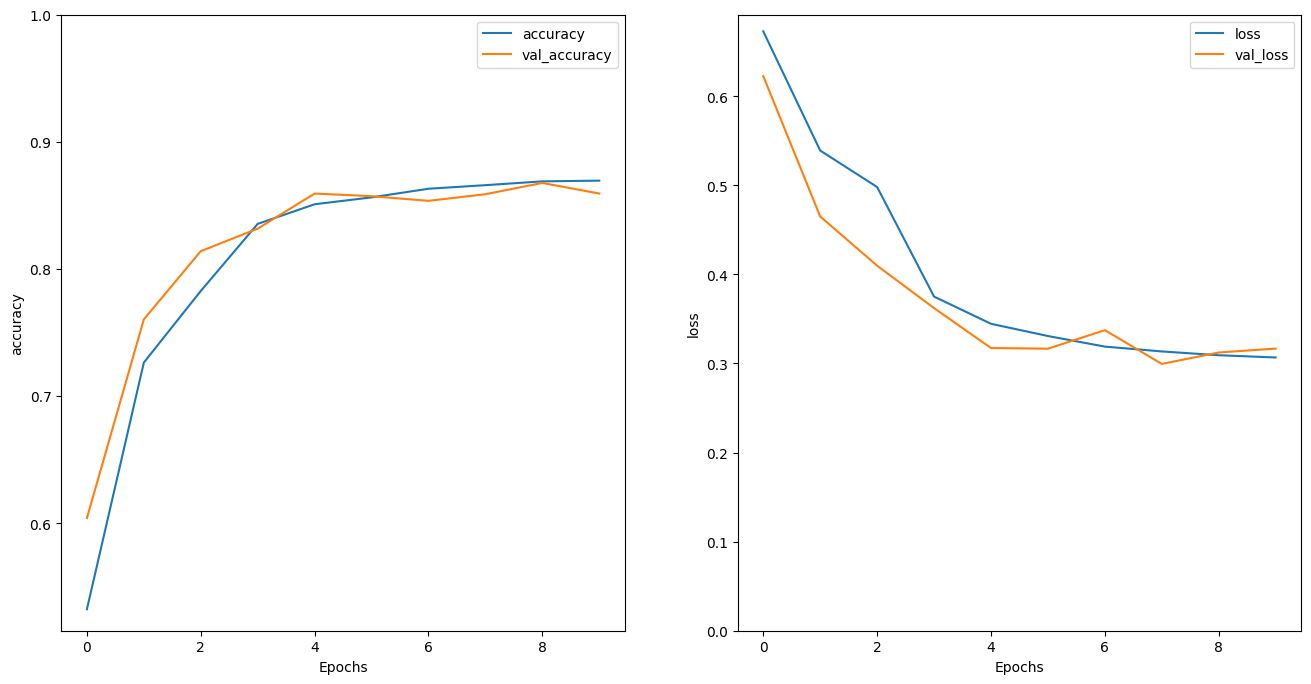

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 32ms/step
[[0.51505655]]


# Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 77s 150ms/step - loss: 0.6256 - accuracy: 0.5926 - val_loss: 0.4323 - val_accuracy: 0.8042
Epoch 2/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3897 - accuracy: 0.8342 - val_loss: 0.3730 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3395 - accuracy: 0.8567 - val_loss: 0.3306 - val_accuracy: 0.8682
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3215 - accuracy: 0.8628 - val_loss: 0.3141 - val_accuracy: 0.8708
Epoch 5/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3117 - accuracy: 0.8674 - val_loss: 0.3345 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3075 - accuracy: 0.8710 - val_loss: 0.3404 - val_accuracy: 0.8328
Epoch 7/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3045 - accuracy: 0.8702 - val_loss: 0.3253 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3315 - accuracy: 0.8613
Test Loss:  0.3315110206604004
Test Accuracy:  0.8612800240516663


In [ ]:
# predict on a sample text without padding

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.7682513]]


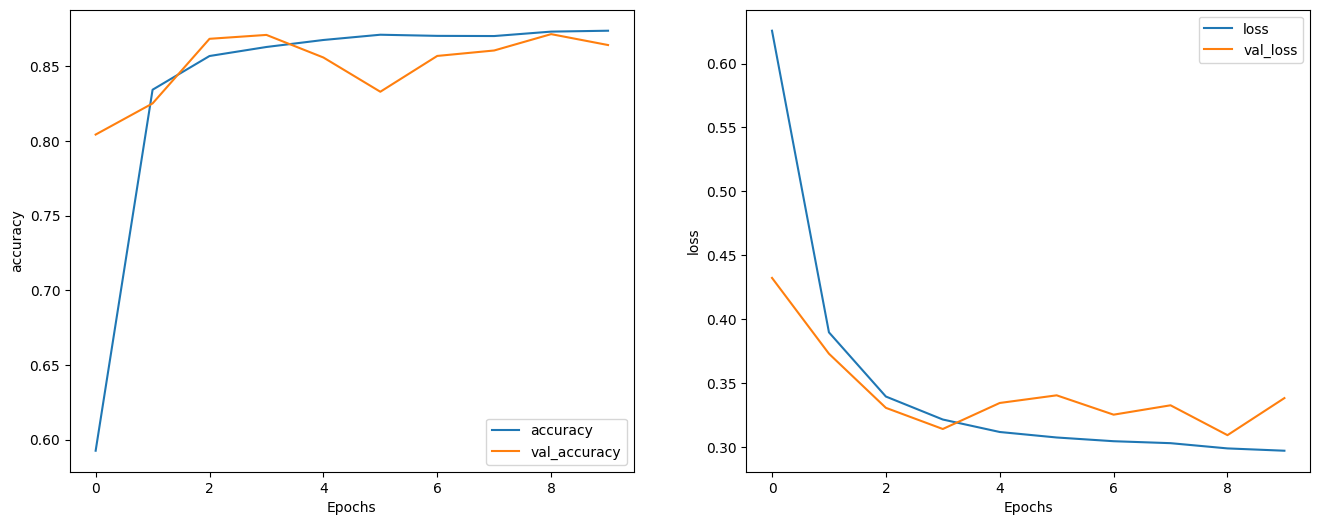

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')